In [ ]:
from google.colab import drive ; drive.mount('/content/drive')
!pip install gym keras keras-rl2 tensorflow==2.1
import os , sys
import pandas as pd 
from datetime import datetime as dt
import time
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
from numpy import loadtxt
from datetime import datetime
from numpy import savetxt
import random ; from random import randint
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense , Flatten 
from tensorflow.keras.optimizers import Adam
from rl.policy import * ; from rl.memory import * ; from rl.agents import *

In [ ]:
#input_shape = ( Memoryin_window_length , ob_space_Length , window )
Memoryin_window_length      = 20
window                      = 360
ob_space_Length             = 5
actions                     = 3
MemoryLimit                 = 200000
#-----------------------------------------------------------
fee                         = 0.0001
SL                          = 0.0020
TP                          = 0.0020
max_nb_trades               = 20
max_nb_steps                = 40

In [ ]:
os.chdir("/content/drive/MyDrive") 
!ls
name = 'DATA/EURUSD.csv'
M1 = pd.read_csv(name, encoding='utf-16',header=None, names=['Date', 'Close'] )
data = M1['Close'].to_numpy()
len(data)

'Colab Notebooks'   Goold  'visual studio 2015 professional iso'
 DATA		    orari   WSaved


7601433

In [ ]:
data = data[ 7000000:len(data)  ]
len(data)

601433

In [ ]:
def show(data):  # data is np
  len1 = len(data)
  plt.figure(figsize=(13, 6))
  x = data[:,0]
  y  = np.arange(start=0, stop=len(x) , step=1) 
  plt.plot(  y ,  x    , label="EURUSD Line" )
  plt.plot(  y ,  data[:,1]  , label="SMA5 Line" )
  plt.plot(  y ,  data[:,2]  , label="SMA10 Line" )
  plt.plot(  y ,  data[:,3]  , label="SMA20 Line" )
  plt.plot(  y ,  data[:,4]  , label="SMA50 Line" )
  plt.show()


def SMA(Data,Periodes):
    #print(' type : {} '.format(type(Data)))
    n = len(Data)-1 
    res = []
    s2 = Data[0]
    res.append(s2)
    for i in range(1,Periodes+1):
        s2 = s2 + Data[i]
        s2 = round( s2/2 ,5 )
        res.append(s2)
        
    for i in range(Periodes,n):
      iSMA = 0
      for j in range(i - Periodes ,i):
        if(j>=n):
          iSMA = iSMA + Data[n]
        else:
          iSMA = iSMA + Data[j]
      iSMA = iSMA/Periodes  
      res.append(iSMA)
    return np.array(res)  
def get_stats360(substats):
  length = len(substats)
  if (length!=(360+50)):
    print(' get360stats is not 360 + 50 data')
    return 0
  else : 
    stats = np.transpose(  [substats , SMA(substats,5) , SMA(substats,10) , SMA(substats,20) , SMA(substats,49)     ]  )
    stats = stats[50:length]
    max = stats.max() 
    min = stats.min()
    stats =   stats/(max-min) - min/(max-min) 
    return stats

In [ ]:
def build_model( ob_space_Length,window , actions,Memoryin_window_length):
    model = Sequential()
    model.add(Dense(128,activation='relu', input_shape=(Memoryin_window_length,ob_space_Length,window) ) )
    model.add(Dense(256, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Flatten())
    model.add(Dense(actions))
    return model    
def build_agent(model, actions,Memoryin_window_length):
    policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.2, nb_steps=10000)
    memory = SequentialMemory(limit= MemoryLimit , window_length=Memoryin_window_length)
    dqn = DQNAgent(model=model, memory=memory, policy=policy,
                  enable_dueling_network=True, dueling_type='avg', 
                   nb_actions=actions, nb_steps_warmup=1000 ,
                   gamma=0.95 
                  )
    return dqn  

In [ ]:
modelive = build_model(ob_space_Length, window, actions,Memoryin_window_length)
dqnlive = build_agent(modelive, actions,Memoryin_window_length)
dqnlive.compile( Adam(lr=1e-4))

In [ ]:
class testingenv(Env ):


        return self.state
#-----------------------------------------------------------------

In [ ]:
AllReward = []
Short = []
stats360 = []

jTime= 1
for i in range(1,20):
  max_nb_steps = i
  
  jDATA=data[jTime:(jTime+360+50) ]
  jstats = get_stats360(jDATA) 
  stats360.append( jstats)
  env = testingenv( np.array(Short) , stats360 )
  _ = dqnlive.test(env, nb_episodes=1, visualize=False  )
  action = env.action
  next_data = data[(jTime+360+50):(jTime+360+50+600) ]
  price = jDATA[len(jDATA)-1]
  reward , find_new_index,Short_ = reward_of_stats( price , action , next_data , SL, TP , fee )
  AllReward.append(reward)
  Short.append([Short_,find_new_index])
  jTime+=find_new_index
  #print('r : {} '.format(reward))

NameError: ignored

In [ ]:
sum(AllReward[0:(len(AllReward)-1)])

-156.00000000000003

# ***8M traning ***

In [ ]:
def reward_of_stats( price , action , next_data , SL, TP , fee ):
  reward = 0     # 0 is action == 2
  find_new_index = 1        # 1 is action == 2
  Short_ = -1
  x = 0
  if(action==0):
    index = 0
    while( index < len(next_data) ):
        newprice = next_data[index]
        if( newprice<= (price-TP) ):
          reward =  TP - fee
          find_new_index = index 
          index = len(next_data) 
          Short_ = 0
          break
        if( newprice>= (price+SL) ):
          reward = -1*SL 
          find_new_index = index 
          index = len(next_data) 
          Short_ = 1
          break
        index +=1 
  #-------------------------------------    
  if(action==1):
    index = 0
    while( index < len(next_data)  ):           
      newprice = next_data[index]
      if( newprice >= (price+TP) ):
        reward =  TP -fee
        find_new_index = index 
        index = len(next_data)
        Short_ = 2
        break
      if( newprice<=(price-SL) ):
        reward = -1*SL 
        find_new_index = index 
        index = len(next_data)
        Short_ = 3
        break
      index +=1 
  if(actions==2):
     reward=0
     Short_=6
     find_new_index = random.randint(2, 10)    
  if(  Short_==-1  ):
    find_new_index = len(next_data)  
    if( action==0 ):
      reward = price - next_data[len(next_data)-1]
      Short_ = 4
    if( action==1 ):
      reward = next_data[len(next_data)-1] - price
      Short_ = 5

  reward = reward*10000  
  find_new_index += random.randint(2, 5) 
  return reward , find_new_index , Short_ 


In [ ]:
class traning_8M(Env ):
    def __init__(self):
         #------------  observation_space  observation_space --------------------------------------------
        global ob_space_Length , window ,max_nb_trades  , TP , SL , fee  , data ,jTime , AllReward , max_nb_steps
        self.observation_space = Box(low= 0.0, high= 1.0, shape=( ob_space_Length ,window), dtype=np.float64 )
        self.action_space = Discrete(2)
        #------------  Parameters --------------------------------------------
        self.iTime_episode=0
        self.action = -1
        self.jDATA = 0
        self.nb_trade = 0
        self.nb_step  = 0
         
    def step(self, action):
        global ob_space_Length , window   , TP , SL , fee  , data ,jTime , max_nb_trades , max_nb_steps
        reward = 0
        self.action = action
        if(action==0 or action==1):
          self.nb_trade+=1
        

        next_data = data[(jTime+360+50-1):(jTime+360+50+700-1) ]
        price = data[(jTime+360+50-1)]
        reward , find_new_index,Short_ = reward_of_stats( price , self.action , next_data , SL, TP , fee )
        AllReward.append(reward)

        

        jTime+=find_new_index

        info_ = {}
        
        if(  (jTime+2000 )>len(data) ):
          jTime = 2
        self.jDATA = data[jTime:(jTime+360+50) ]
        jstats = get_stats360(self.jDATA) 
        self.state = jstats
        self.state = np.transpose(self.state)

        self.iTime_episode+=1
        done = False
        if( self.nb_trade>=max_nb_trades or self.nb_step>=max_nb_steps ):
          done = True
        return self.state, reward, done, info_
    def render(self):
        g=0
    def reset(self):
        global ob_space_Length , window   , TP , SL , fee , max_nb_steps , data ,jTime 
        print(' jTime :{} '.format(jTime))
        self.nb_trade=0
        self.nb_step  = 0
        if(  (jTime+2000 )>len(data) ):
          jTime = 2
        self.jDATA=data[jTime:(jTime+360+50) ]
        jstats = get_stats360(self.jDATA) 
        self.state = jstats
        self.state = np.transpose(self.state)
        return self.state
#-----------------------------------------------------------------
env_8M = traning_8M(  )

In [ ]:
jTime = 1
FileVersion = "WSaved/V67/"
time = datetime.now()
time = time.strftime("%H-%M-%S")
render = 0
steps = 2000000000
Looping = 1
NameSaving = "testing"
for i in range(0,Looping):
  dqnlive.fit( env_8M , nb_steps=steps, visualize=False, verbose=2)
  time_ = datetime.now()
  time_ = time_.strftime("%H-%M-%S")
  NameSaving = FileVersion+time_+'/' +"WSaveddqn_"+str(time_)+".h5f"
  print('IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII') 
  print(NameSaving)
  print('IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII')
  dqnlive.save_weights(NameSaving, overwrite=True)

Reloud Model


In [ ]:

name = 'WSaved/n3/WSaveddqn_11-34-38.h5f'
dqnlive.load_weights(name)

Testing for 30 episodes ...
 jTime :1 
Episode 1: reward: 98.200, steps: 34
 jTime :20698 
Episode 2: reward: -1.300, steps: 29
 jTime :34012 
Episode 3: reward: -20.600, steps: 36
 jTime :52487 
Episode 4: reward: 31.500, steps: 38
 jTime :73897 
Episode 5: reward: -30.600, steps: 28
 jTime :87084 
Episode 6: reward: -45.400, steps: 27
 jTime :101003 
Episode 7: reward: 58.600, steps: 25
 jTime :114070 
Episode 8: reward: -157.700, steps: 23
 jTime :124407 
Episode 9: reward: -34.500, steps: 33
 jTime :140045 
Episode 10: reward: 103.100, steps: 31
 jTime :159270 
Episode 11: reward: 65.100, steps: 31
 jTime :175766 
Episode 12: reward: -15.400, steps: 33
 jTime :195650 
Episode 13: reward: 84.400, steps: 29
 jTime :213158 
Episode 14: reward: 111.100, steps: 26
 jTime :228372 
Episode 15: reward: 36.800, steps: 36
 jTime :247646 
Episode 16: reward: -105.500, steps: 44
 jTime :266791 
Episode 17: reward: 107.000, steps: 29
 jTime :275303 
Episode 18: reward: 50.300, steps: 48
 jTime 

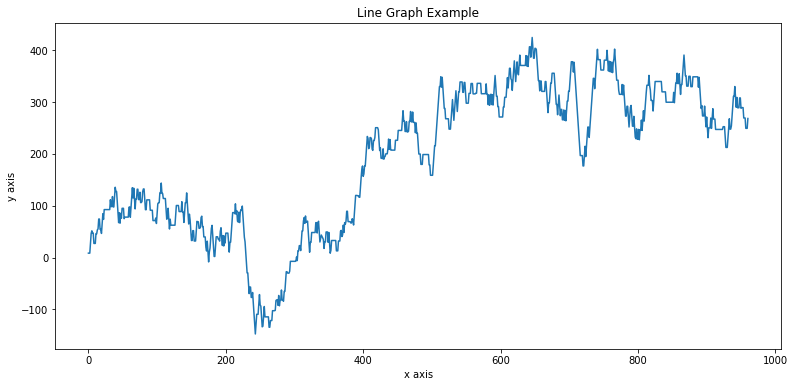

In [ ]:
  AllReward = []
  jTime = 1
  dqnlive.test(env_8M,nb_episodes=30,visualize=False)
  print( ' All Rewards :{} '.format( sum(AllReward) ) )
  ShowV3()

In [ ]:
p = 0
for i in range(0, len(AllReward)-1 ):
    p+=1
p    

5748

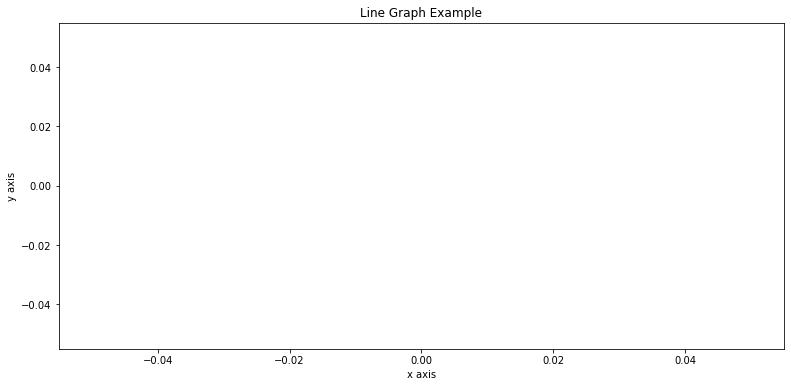

In [ ]:
def ShowV3():
  R = AllReward
  x = []
  s = 0
  for i in range(0,len(R)):
    s = s + R[i]
    x.append(s)
  y = np.arange(0,len(R) ) 
  plt.figure(figsize=(13, 6))
  plt.plot( y, x, label="US30 Line") 
  plt.xlabel("x axis")
  plt.ylabel("y axis")
  plt.title("Line Graph Example")
  plt.show()  # 200
ShowV3()

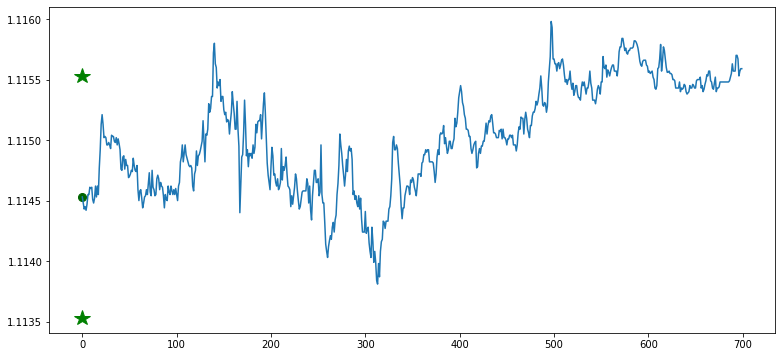

In [ ]:
b = 214022 +5
def showV6(b):  # data is np
  plt.figure(figsize=(13, 6))
  x = data[b:(b+700)]
  y  = np.arange(start=0, stop=len(x) , step=1) 
  price = data[b]
  plt.plot( 0  , price ,  marker='.', markersize=16, color="darkgreen") 
  plt.plot(  0 , price + 0.001 ,  marker='*', markersize=16, color="green") 
  plt.plot(  0 , price - 0.001 ,  marker='*', markersize=16, color="green") 
  plt.plot(  y ,  x    , label="EURUSD Line" )
  plt.show()

showV6(b)